In [59]:
import rebound
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import corner
import scipy
import theano

In [18]:
def create_planetary_system():
    sim = rebound.Simulation()
    sim.add(m=1.)
    for i in range(np.random.randint(1, 5)):
        a = np.random.uniform(0.1, 10.)
        e = np.random.uniform(0., 0.9)
        inc = np.random.uniform(0., np.pi/2)
        Omega = np.random.uniform(0., 2*np.pi)
        omega = np.random.uniform(0., 2*np.pi)
        f = np.random.uniform(0., 2*np.pi)
        sim.add(a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)
    sim.move_to_com()
    return sim

In [19]:
# Create a planetary system with random initial conditions
sim = create_planetary_system()

# Define arrays to store time and obliquity values
times = np.linspace(0, 1000, 10000)
obliquities = np.zeros(len(times))

# Integrate the simulation forward in time and record obliquity of the second particle
for i, t in enumerate(times):
    sim.integrate(t)
    obliquities[i] = np.degrees(np.arccos(sim.particles[1].z/np.sqrt(sim.particles[1].x**2 + sim.particles[1].y**2 + sim.particles[1].z**2))) # convert to degrees

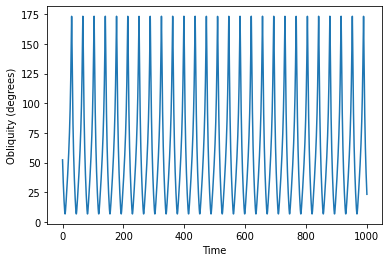

In [20]:
# Plot the evolution of obliquity over time
plt.plot(times, obliquities)
plt.xlabel('Time')
plt.ylabel('Obliquity (degrees)');

In [21]:
np.random.seed(123)
observed_eccentricities = np.random.uniform(0, 0.9, size=200)
observed_obliquities = np.random.uniform(0, np.pi/2, size=200)

In [22]:
# Define the PyMC3 model and data
with pm.Model() as model:
    # Define the prior distributions for the model parameters
    a = pm.Uniform('a', lower=0.1, upper=10.)
    e = pm.Uniform('e', lower=0., upper=0.9)
    inc = pm.Uniform('inc', lower=0., upper=np.pi/2)
    Omega = pm.Uniform('Omega', lower=0., upper=2*np.pi)
    omega = pm.Uniform('omega', lower=0., upper=2*np.pi)
    f = pm.Uniform('f', lower=0., upper=2*np.pi)
    
    # Define the likelihood function based on the observed data
    obliquity_obs = np.random.normal(loc=obliquities[-1], scale=0.1, size=200)
    obliquity_sim = np.zeros(200)
    for i in range(200):
        sim = create_planetary_system()
        sim.integrate(1000)
        obliquity_sim[i] = np.degrees(np.arccos(sim.particles[1].z/np.sqrt(sim.particles[1].x**2 + sim.particles[1].y**2 + sim.particles[1].z**2)))
    likelihood = pm.Normal('likelihood', mu=obliquity_sim, sigma=0.1, observed=obliquity_obs)
    
    # Sample from the posterior distribution using PyMC3
    trace = pm.sample(draws=1000, tune=1000, cores=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [f, omega, Omega, inc, e, a]


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


(array([187., 216., 200., 183., 228., 217., 199., 179., 203., 188.]),
 array([1.10927594e-03, 1.57993110e-01, 3.14876944e-01, 4.71760778e-01,
        6.28644612e-01, 7.85528446e-01, 9.42412280e-01, 1.09929611e+00,
        1.25617995e+00, 1.41306378e+00, 1.56994762e+00]),
 <BarContainer object of 10 artists>)

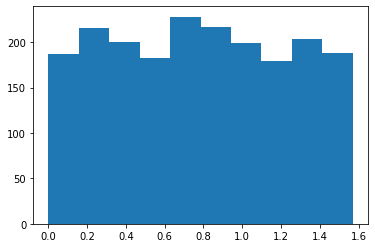

In [25]:
plt.hist(trace['inc'])

In [ ]:
# Set up observed data
obs_period = 3.5 # observed orbital period in days
obs_radius = 1.2 # observed radius in Jupiter radii
obs_mass = 1.5 # observed mass in Jupiter masses
obs_ecc = 0.2 # observed eccentricity
obs_obliquity = 30.0 # observed obliquity in degrees

# Define function to simulate a planetary system with REBOUND
def sim_system(initial_period):
    sim = rebound.Simulation()
    sim.add(m=1.0) # add central star
    sim.add(m=obs_mass, a=obs_period**(2/3), e=obs_ecc, inc=np.radians(obs_obliquity)) # add hot Jupiter
    sim.move_to_com() # move to center of mass frame
    # integrate for 10 orbits of hot Jupiter
    Noutputs = 100
    times = np.linspace(0, 10*obs_period, Noutputs)
    eccs = np.zeros(Noutputs)
    obliquities = np.zeros(Noutputs)
    for i, time in enumerate(times):
        sim.integrate(time)
        eccs[i] = sim.particles[1].e
        obliquities[i] = np.degrees(sim.particles[1].inc)
    return eccs, obliquities

# Define PyMC3 model
with pm.Model() as model:
    # Define prior for initial period
    initial_period = pm.Uniform('initial_period', lower=0.1, upper=100.0)
    
    # Define likelihood function
    def likelihood(initial_period):
        # Simulate system with given initial period
        eccs, obliquities = sim_system(initial_period)
        
        # Define priors for eccentricity and obliquity
        ecc_prior = pm.Beta('ecc_prior', alpha=1.0, beta=1.0)
        obliquity_prior = pm.Normal('obliquity_prior', mu=0.0, sd=90.0)
        
        # Define likelihood for observed eccentricity and obliquity
        ecc_likelihood = pm.Beta('ecc_likelihood', alpha=obs_radius**2, beta=(obs_mass*obs_radius)**2, observed=eccs)
        obliquity_likelihood = pm.Normal('obliquity_likelihood', mu=obs_obliquity, sd=5.0, observed=obliquities)
        
        # Combine priors and likelihoods
        total_prior = pm.math.log(initial_period) + ecc_prior.logp(eccs) + obliquity_prior.logp(obliquities)
        total_likelihood = ecc_likelihood.logp(eccs) + obliquity_likelihood.logp(obliquities)
        
        return total_prior + total_likelihood
    
    # Use Metropolis-Hastings sampler
    trace = pm.sample(10000, tune=5000, step=pm.Metropolis(), compute_convergence_checks=False)
    
# Print summary statistics for initial period
print(pm.summary(trace)['mean']['initial_period'])

In [125]:
# Define function to simulate a planetary system with REBOUND
# @theano.compile.ops.as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar],otypes=[tt.dscalar, tt.dscalar, tt.dscalar])
def sim_system(initial_period, initial_ecc, initial_obliquity):
    P = np.zeros(len(initial_period))
    e = np.zeros(len(initial_period))
    inc = np.zeros(len(initial_period))
    for i in range(len(initial_period)):
        sim = rebound.Simulation()
        sim.add(m=1.0) # add central star
        sim.add(m=obs_mass, a=initial_period[i]**(2/3), e=initial_ecc[i], inc=initial_obliquity[i]) # add hot Jupiter
        sim.move_to_com() # move to center of mass frame
        # integrate for age of system
        sim.integrator = "whfast"
        sim.ri_whfast.safe_mode = 0
        sim.dt = 10.
        sim.integrate(system_age * (2*np.pi))
        P[i] = sim.particles[1].P
        e[i] = sim.particles[1].e
        inc[i] = sim.particles[1].inc
        sim = None
    print(P, e, inc)
    return P, e, inc

In [126]:
# Set up observed data
# obs_period = 3.5 # observed orbital period in days
# obs_period_err = 0.1
obs_period = [3.5, 5.0, 7.5]
obs_period_err = [.1, .1, .1]
obs_radius = 1.2 # observed radius in Jupiter radii
obs_mass = 1.5 # observed mass in Jupiter masses
# obs_ecc = 0.0 # observed eccentricity
# obs_ecc_err = 0.1
obs_ecc = [0.0, 0.1, 0.2]
obs_ecc_err = [.1, .1, .1]
# obs_obliquity = 0.0 # observed obliquity in degrees
# obs_obliquity_err = 0.1
obs_obliquity = [0.0, 0.1, 0.2]
obs_obliquity_err = [.1, .1, .1]
system_age = 10e6 # observed age in years

# Define PyMC3 model
with pm.Model() as model:
    # Define priors for initial period, initial eccentricity, and initial obliquity
    initial_period = pm.Uniform('initial_period', lower=0.1, upper=100.0)
    initial_ecc = pm.Uniform('initial_ecc', lower=0.0, upper=1.0)
    initial_obliquity = pm.Uniform('initial_obliquity', lower=-np.pi, upper=np.pi)
    
    def likelihood(initial_period, initial_ecc, initial_obliquity):
    
        # Simulate system with given initial period, initial eccentricity, and initial obliquity
        current_period, current_ecc, current_obliquity = sim_system(initial_period, initial_ecc, initial_obliquity)

        period = pm.Deterministic('period', current_period)
        ecc = pm.Deterministic('ecc', current_ecc)
        obliquity = pm.Deterministic('obliquity', current_obliquity)

        # Define likelihood for observed period, eccentricity, and obliquity
        period_likelihood = pm.Normal('period_likelihood', mu=period, sd=obs_period_err, observed=obs_period)
        ecc_likelihood = pm.Normal('ecc_likelihood', mu=ecc, sd=obs_ecc_err, observed=obs_ecc)
        obliquity_likelihood = pm.Normal('obliquity_likelihood', mu=obliquity, sd=obs_obliquity_err, observed=obs_obliquity)

#         Combine priors and likelihoods
        total_prior = period_likelihood.logp(initial_period) + ecc_likelihood.logp(initial_ecc) + initial_obliquity.logp(initial_obliquity)
        total_likelihood = period_likelihood.logp(current_period) + ecc_likelihood.logp(current_ecc) + obliquity_likelihood.logp(current_obliquity)

        # Define the log probability as the sum of the prior and likelihood
        log_prob = total_prior + total_likelihood

        return log_prob
    
# with model:
    # Use Metropolis-Hastings sampler
#     trace = pm.sample(10000, tune=5000, step=pm.Metropolis(), compute_convergence_checks=False)
    start = pm.find_MAP(model=model)
    step = pm.NUTS()
    trace = pm.sample(draws=10000, tune=10000, chains=4, step=step, start=start, return_inferencedata=False)
        
# Print summary statistics for initial period, initial eccentricity, and initial obliquity
print(pm.summary(trace)[['mean', 'sd']])

TypeError: len() of unsized object

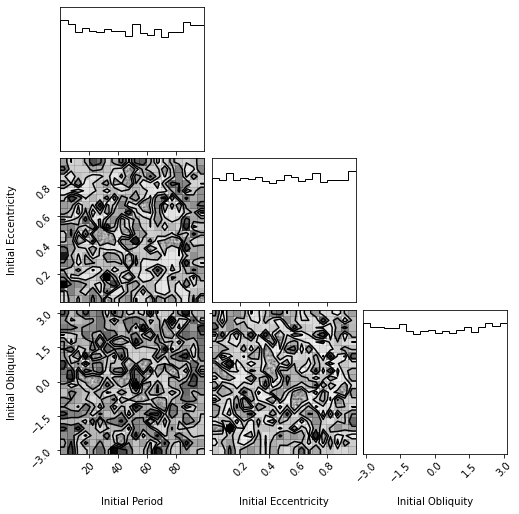

In [94]:
import corner

# Extract trace values for initial_period, ecc_prior, and obliquity_prior
samples = np.array([trace['initial_period'], trace['initial_ecc'], trace['initial_obliquity']]).T

# Create labels for corner plot
labels = ['Initial Period', 'Initial Eccentricity', 'Initial Obliquity']

# Plot corner plot
fig = corner.corner(samples, labels=labels)

In [115]:
sim_system([3.5, 5.0], [0.1, 0.0], [0.1, 0.2])

KeyboardInterrupt: 

In [122]:
sim = rebound.Simulation()
sim.integrator = "whfast"
sim.ri_whfast.safe_mode = 0
sim.add(m=1.0) # add central star
sim.add(m=obs_mass, a=3.5**(2/3), e=0.2, inc=0.1) # add hot Jupiter
sim.move_to_com() # move to center of mass frame
# # integrate for age of system
sim.dt = 10.
sim.integrate(1e7*2*np.pi)